# Kalorimeter-Skript


In [1]:
import os, math
import pandas as pd
import matplotlib.pyplot as plt
import tkinter as tk
from tkinter import filedialog

Funktionen, um die Rohdaten zu verarbeiten.

In [2]:
# Massen werden sowohl in g als auch in mg angegeben
# diese Funktion vereinheitlicht die Masse zu g
# mass_string 
def parse_mass( mass_string ): # rechne mg automatisch in g um
    return float(mass_string[:-2])/1000 if mass_string[-2:] == 'mg' else float(mass_string[:-1]) #entferne Einheit (durch [:-1] bzw [:-2])

# Verarbeitung des ersten Sheets "Experiment info"
def get_experiment_info(pfad):
    # lade Excelsheet
    experiment_info = pd.read_excel(pfad, sheet_name="Experiment info")
    
    # extrahiere Zeiten
    st_i = experiment_info.loc[experiment_info['Summary'] == 'Start time'].index[0] # Zeilennummer der Startzeit in der Excel Tabelle
    start_time = experiment_info.iat[st_i, 1]

    et_i = experiment_info.loc[experiment_info['Summary'] == 'End time'].index[0] # Zeilennummer der Endzeit in der Excel Tabelle
    end_time   = experiment_info.iat[et_i, 1]

    # extrahiere Badtemperatur
    i_bt = experiment_info.loc[experiment_info['Summary'] == 'Bath temperature'].index[0] # Zeilennummer der Bad-Temp in der Excel Tabelle
    bath_temp = experiment_info.iat[i_bt, 1]
    bath_temp = bath_temp[:-2] # entferne °C
  
    # extrahiere Probennummer und Komponenten
    component_names  = experiment_info.loc[experiment_info['Summary'] == 'Name']
    component_masses = experiment_info.loc[experiment_info['Summary'] == 'Mass']
    specimen_name    = component_names.iat[0,1][:-5]
    specimen_name    = specimen_name.upper().split('Z')
    experiment_nr    = specimen_name[0]
    experiment_cell  = specimen_name[1]

    print( 'Experiment #{} in Zelle {} vom {} wurde geladen'.format(experiment_nr, experiment_cell,  start_time.strftime("%d.%m.%Y, %H:%M Uhr")) )
    print( ' - Messdauer: {}'.format(end_time - start_time) )
    print( ' - Badtemperatur: {}°C'.format(bath_temp))
    print( ' - {} Komponenten: '.format( len(component_masses) ) )

    total_mass = 0
    # extrahiere Massen und Namen der Komponenten
    data_column = experiment_info.columns[1]          # Python-Interner Name der Daten-Spalte
    components = []                                   # leere Liste, in der die Namen und Massen gespeichert werden
    j = 1
    for row in component_masses.iterrows():
        i    = row[0]                                 # Zeilennummer der Masse in der Excel Tabelle
        mass = row[1][data_column]                    # Masse
        
        mass = parse_mass(mass) # Masse ohne die Einheit
        name = component_names.loc[i+1][data_column] # Der Name befindet sich in der nächsten Zeilennummer
        components.append( {
                'name': name, 
                'mass': mass  
        } )
        print( '    {:02}. {}: {} g'.format(j, name, mass) )
        total_mass += mass
        j += 1

    tm_result = experiment_info.loc[experiment_info['Summary'] == 'Total mass']
    if len(tm_result) > 0:
        i = experiment_info.loc[experiment_info['Summary'] == 'Total mass'].index[0] # Zeilennummer der Bad-Temp in der Excel Tabelle
        total_mass = parse_mass(experiment_info.iat[i, 1])
        experiment_name = experiment_info.iat[i+1, 1]
    else:
        experiment_name = ''#experiment_info.iat[i_bt+1, 1]   

    return { 
        'experiment_nr'     : experiment_nr, 
        'experiment_cell'   : experiment_cell, 
        'start_time'        : start_time,
        'end_time'          : end_time,
        'bath_temp'         : bath_temp,
        'components'        : components,
        'total_mass'        : total_mass,
        'experiment_name'   : experiment_name
    }

# verarbeite das Datensheet "Raw data" 
def process_data(pfad):
    data_df = pd.read_excel(pfad, sheet_name="Raw data", header=[0,1])

    time_column      = data_df.columns[0]
    norm_heat_column = data_df.columns[6]
    start_length = len(data_df)
    
    #data_df = data_df[data_df[time_column].notnull()] # entferne Zeilen mit NaN
    data_df = data_df[data_df[time_column] >= 0]                    # nur Zeit > 0
    data_df.drop(list(data_df.filter(regex='Time markers')), axis=1, inplace=True)         # entferne Time markers Spalte(n)

    
    # versuche letzten negative Werte von Normalized heat zu finden und bei einem stabil positiven Wert anzufangen. 
    # Manchmal schwankt der Wert ins positive und dann wieder ins negative, daher reicht die simple Variante nicht.
    data_df = data_df[data_df[norm_heat_column] >= 0]               # nur Normalized heat > 0
    data_df.reset_index(drop=True, inplace=True)                    # neu durchzählen
    start_index = 0
    last_value_negative = False
    for index, row in data_df.iloc[:100].iterrows():                # gehe nur durch die ersten 100 Zeilen, da es sehr unwahrscheinlich ist, dass der Wert sich nach 1000 Sekunden nicht oberhalb 0 eingependelt hat
        if last_value_negative: start_index = index                 # wenn beim letzten Durchlauf eine negative Zahl gefunden wurde, wird start_index aktualisiert
        last_value_negative = row[norm_heat_column] < 0             # prüfe, ob ein negativer Normalized heat Wert vorliegt
    data_df = data_df.iloc[start_index:-1]                          # entferne alles bis zum Start_index und die letzte Zeile
    data_df.reset_index(drop=True, inplace=True)                    # neu durchzählen
    time_delta = data_df.iat[0,0]                                   # finde das Time-Delta des letzten 

    data_df[time_column] = data_df[time_column] - time_delta       # setze die Startzeit wieder auf null (Abziehen der kleinsten Zeit von allen Messungen)

    # berechnet Zieldaten
    data_df[('Normalized heat rate', 'dQ/dt [J/gh]')] = data_df[data_df.columns[5]]*3600
    data_df[('Hours', 't [J/gh]')] = data_df[time_column]/3600
    
    # neue Spaltennamen
    data_df.columns = [
        'Seconds [s]',
        'Ambient temperature [°C]',
        'Temperature [°C]',
        'Heat flow [W]',
        'Heat [J]',
        'Normalized heat flow [W/g]',
        'Normalized heat Q(t) [J/g]',
        'Normalized heat rate dQ/dt [J/gh]',
        'Hours [h]'
    ]
    # neue Spaltenreihenfolge
    data_df = data_df[ [
        'Seconds [s]',
        'Hours [h]',
        'Ambient temperature [°C]',
        'Temperature [°C]',
        'Heat flow [W]',
        'Heat [J]',
        'Normalized heat flow [W/g]',
        'Normalized heat Q(t) [J/g]',
        'Normalized heat rate dQ/dt [J/gh]',
    ] ]
    
    print(" - Mittlere Probentemperatur {:.5f} °C +- {:.5f} °C (max {:.5f} °C, min {:.5f} °C)".format( data_df['Temperature [°C]'].mean(), data_df['Temperature [°C]'].std(), data_df['Temperature [°C]'].max(), data_df['Temperature [°C]'].min() ))
    print(" - {} Datenzeilen geladen ({:.2f} Tage), {} Zeilen verworfen".format(len(data_df), data_df.iat[-1,1]/24, start_length-len(data_df)))
    return data_df

# Wrapperfunktion, das die Datenextration triggert
def process_file(directory, filename, result_path = ''):
    experiment_info  = get_experiment_info( directory + filename )
    data_df          = process_data(        directory + filename )

    experiment_label = "#{} Z{}: ".format( experiment_info['experiment_nr'], experiment_info['experiment_cell'] )
    xlsx_sheet_label = "{}-".format(       experiment_info['experiment_name'] ) if experiment_info['experiment_name'] != '' else ''
    delimiter = ''
    for c in experiment_info['components']:
        experiment_label += delimiter + c['name']
        xlsx_sheet_label += delimiter + c['name']
        delimiter = '+'
    
    return xlsx_sheet_label, experiment_info, data_df

Funktionen für die Ausgabe in Excel und als Graphen

In [3]:
def generate_fast_graphs(loaded_data, x_axis_id=1, y_axis_id=6, y_log=False, result_path='./', file_name='diagram'):
    time_max = 0
    data_max = 0
    fig, ax = plt.subplots(figsize=(9,5))
    for experiment_label, data in loaded_data.items():
        hour_column   = data['data_df'].columns[x_axis_id]
        max = data['data_df'].iat[-1,1]
        if time_max < max: time_max = max
        
        n_heat_column = data['data_df'].columns[y_axis_id]
        max = data['data_df'][n_heat_column].max()
        if data_max < max: data_max = max
        
        ax.plot(data['data_df'][hour_column], data['data_df'][n_heat_column], label=experiment_label)  # Plot some data on the Axes.

    time_max = math.ceil(time_max/24)*24
    ax.set_xlabel(hour_column)
    ax.set_xticks(range(0,time_max,24))
    ax.set_xlim([-1,time_max])

    ax.set_ylabel(n_heat_column)
    ax.set_ylim([0,data_max*1.05])
    if y_log: ax.set_yscale('log')
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    plt.tight_layout()
    plt.savefig(result_path + file_name + '.png')
    plt.savefig(result_path + file_name + '.svg')
    plt.show()

def clean_sheet_name(sheet_name):
    # bestimmte Zeichen sind nicht in Excel-Sheet-Namen zugelassen
    for i in ['[',']',':','*','?','/',"\\"]:
        sheet_name = sheet_name.replace(i, '-')
    return sheet_name

def insert_chart(workbook, worksheet, experiment_label, data_df, col_index, coord):
    chart = workbook.add_chart({'type': 'scatter', "subtype": "straight"})
    chart.set_title({
        'name': '{} - {}'.format(data_df.columns[col_index], experiment_label),
        'name_font': {
            'name': 'Calibri',
            'size': 10
        },
    })
    # Configure the series of the chart from the dataframe data.
    chart.add_series({
        'categories': [experiment_label, 1, 1, len(data_df), 1],
        'values':     [experiment_label, 1, col_index, len(data_df), col_index],
    })

    # Configure the chart axes.
    chart.set_x_axis({'name': data_df.columns[1], 'position_axis': 'on_tick'})
    chart.set_y_axis({'name': data_df.columns[col_index], 'major_gridlines': {'visible': False}})

    # Turn off chart legend. It is on by default in Excel.
    chart.set_legend({'position': 'none'})
    worksheet.insert_chart(coord, chart)
    
def insert_multi_chart(workbook, worksheet, loaded_data, col_index, coord):
    chart = workbook.add_chart({'type': 'scatter', "subtype": "straight"})
    for experiment_label, data in loaded_data.items():
        experiment_label = clean_sheet_name(experiment_label)
        # Configure the series of the chart from the dataframe data.
        chart.add_series({
            'categories': [experiment_label, 1, 1, len(data['data_df']), 1],
            'values':     [experiment_label, 1, col_index, len(data['data_df']), col_index],
            'name': experiment_label
        })

    chart.set_title({
        'name': '{}'.format(data['data_df'].columns[col_index]),
        'name_font': {
            'name': 'Calibri',
            'size': 10
        },
    })
    
    # Configure the chart axes.
    chart.set_x_axis({'name': data['data_df'].columns[1], 'position_axis': 'on_tick'})
    chart.set_y_axis({'name': data['data_df'].columns[col_index], 'major_gridlines': {'visible': False}})
    chart.set_legend({
        'name_font': {
            'name': 'Calibri',
            'size': 8
        }})

    # Turn off chart legend. It is on by default in Excel.
    worksheet.insert_chart(coord, chart)

Durchsuchen des Verzeichnisses mit den Rohdaten und anlegen des Auswertungsordners

In [4]:
# Öffnet den Ordner auswählen Dialog und speichert den ausgewählten Ordner
root = tk.Tk()
root.withdraw()
root.wm_attributes('-topmost', 1) # Fenster immer im Vordergrund
directory = filedialog.askdirectory(title='Bitte das Arbeitsverzeichnis mit den XLS Ergebnis-Dateien der DCA auswählen.')
directory = directory + os.sep
root.destroy()

# erstelle Auswertung Ordner, falls nicht vorhanden
result_path = directory + 'Auswertung' + os.sep
if not os.path.isdir(result_path):
    os.mkdir(result_path)
    
# durchsuche den Ordner nach XLS Dateien
fileList = []
for filename in os.listdir( directory ):
    if filename.endswith(".xls"):
        fileList.append(filename)
        
print('{} XLS Dokumente gefunden.'.format(len(fileList)))

4 XLS Dokumente gefunden.


Hauptprogrammschleife zum Verarbeiten der Rohdaten.

In [5]:
experiments_overview = []
loaded_data = {}
for filename in fileList:
    xlsx_sheet_label, experiment_info, data_df = process_file( directory, filename, result_path )
    
    loaded_data[xlsx_sheet_label] = experiment_info
    loaded_data[xlsx_sheet_label]['data_df'] = data_df
    print('-'*20)
    
    # Bereite Daten für experiment_overview.xlsx vor
    components = ''
    delimiter  = ''
    for c in experiment_info['components']:
        components += delimiter + str(c['mass']) +'g ' + c['name']
        delimiter   = '+' 
    
    # Übersichtstabelle aller Experimente erstellen
    table = {
        "Experiment #":     experiment_info['experiment_nr'],
        "Experiment Name":  experiment_info['experiment_name'],
        "Zelle":            experiment_info['experiment_cell'],
        "Datum":            experiment_info['start_time'],
        "Messzeit in h":    data_df.iat[-1,1],
        "Komponenten":      components,
        "Gesamtmasse in g": experiment_info['total_mass'],
        "T mean":           data_df['Temperature [°C]'].mean(),
        "T std":            data_df['Temperature [°C]'].std(),
        "T min":            data_df['Temperature [°C]'].min(),
        "T max":            data_df['Temperature [°C]'].max()
    }
    
    # Wärme zu bestimmten Zeiten ausgeben
    norm_heat_times = {1,2,3,7}
    for time in norm_heat_times:
        temp = data_df.loc[data_df['Hours [h]'] >= time*24, 'Normalized heat Q(t) [J/g]']
        # Zahl ausgeben, wenn zum Zeitpunkt eine Messung existiert oder '-', wenn nicht.
        table["Norm. heat Q({}d) in J/g".format(time)] = temp.values[0] if len(temp>0) else '-'
        
    experiments_overview.append(table)
    
# speichere experiment_overview.xlsx
experiments_overview_df = pd.DataFrame(experiments_overview)


Experiment #010724 in Zelle 1 vom 04.07.2024, 10:57 Uhr wurde geladen
 - Messdauer: 10 days, 23:17:14.252000
 - Badtemperatur: 25°C
 - 2 Komponenten: 
    01. SSC-3: 3.0 g
    02. H2O: 1.499 g
 - Mittlere Probentemperatur 24.99940 °C +- 0.00106 °C (max 25.00124 °C, min 24.99528 °C)
 - 61936 Datenzeilen geladen (10.75 Tage), 1252 Zeilen verworfen
--------------------
Experiment #090424 in Zelle 1 vom 23.04.2024, 06:09 Uhr wurde geladen
 - Messdauer: 7 days, 3:41:55.371000
 - Badtemperatur: 25°C
 - 2 Komponenten: 
    01. H2O: 1.501 g
    02. SCC-BM: 3.0 g
 - Mittlere Probentemperatur 24.99940 °C +- 0.00082 °C (max 25.00116 °C, min 24.99460 °C)
 - 41026 Datenzeilen geladen (7.12 Tage), 181 Zeilen verworfen
--------------------
Experiment #150824 in Zelle 7 vom 13.08.2024, 07:56 Uhr wurde geladen
 - Messdauer: 7 days, 1:17:10.810000
 - Badtemperatur: 25°C
 - 2 Komponenten: 
    01. SCC-BM2: 3.001 g
    02. H2O: 1.499 g
 - Mittlere Probentemperatur 24.99940 °C +- 0.00105 °C (max 25.00133 °

Erstellen von übersichtsgraphen.

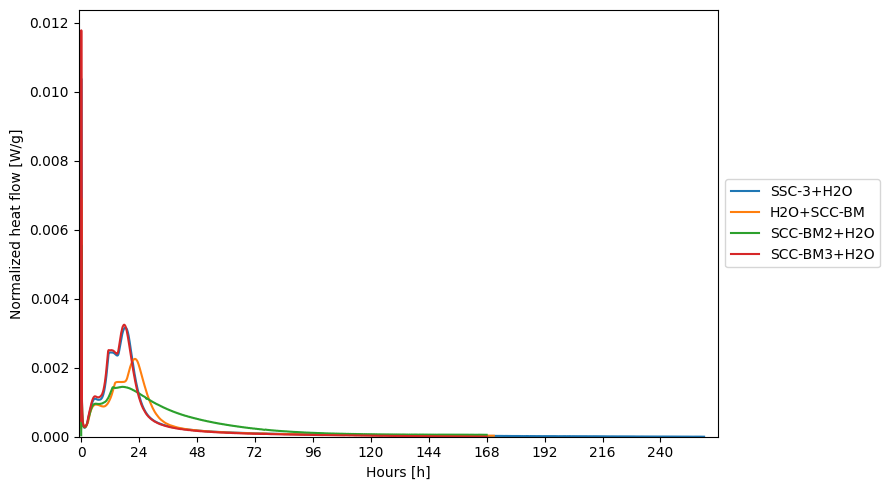

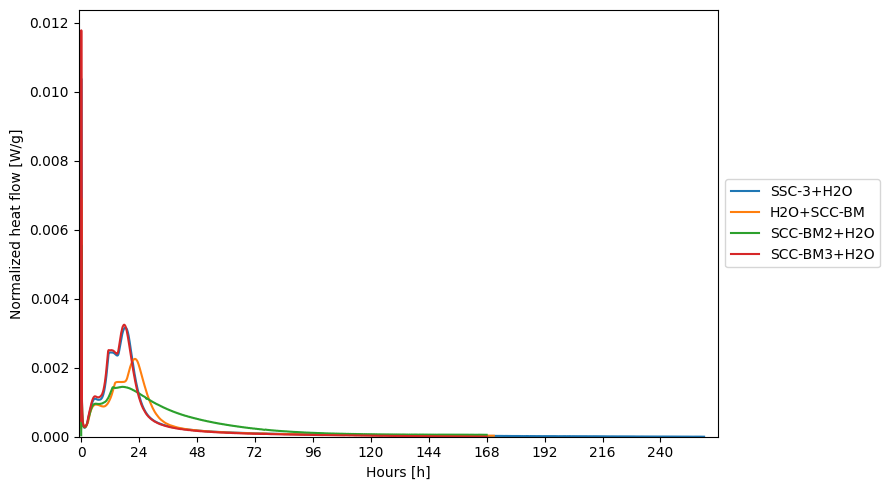

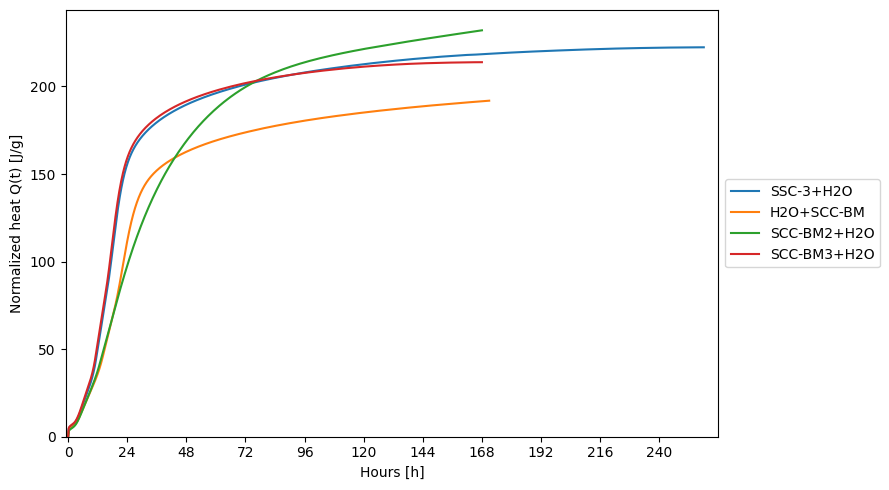

In [6]:
generate_fast_graphs(loaded_data, x_axis_id=1, y_axis_id=6, result_path=result_path, file_name='sum_heat_flow')
generate_fast_graphs(loaded_data, x_axis_id=1, y_axis_id=6, result_path=result_path, file_name='sum_heat_flow_log', y_log=False)
generate_fast_graphs(loaded_data, x_axis_id=1, y_axis_id=7, result_path=result_path, file_name='norm_heat')

kleine Exceldatei mit einer Experimentsübersicht zum schnellen Öffnen erstellen

In [7]:
writer = pd.ExcelWriter(result_path+'experiment_overview.xlsx', engine='xlsxwriter')
experiments_overview_df.to_excel(writer, sheet_name = 'Verarbeitete Experimente', index=False)
# save excel
writer.close()

In [8]:
#initialze the excel writer
writer = pd.ExcelWriter(result_path+'Combined_results.xlsx', engine='xlsxwriter')
sheet_name = 'Experimentübersicht'
experiments_overview_df.to_excel(writer, sheet_name = sheet_name, index=False)

workbook = writer.book
worksheet = writer.sheets[sheet_name]
insert_multi_chart(workbook, worksheet, loaded_data, 8, 'P2')
insert_multi_chart(workbook, worksheet, loaded_data, 7, 'P17')

for experiment_label, data in loaded_data.items():
    experiment_label = clean_sheet_name(experiment_label)
    data['data_df'].to_excel(writer, sheet_name = experiment_label, index=False)
    
    # Access the XlsxWriter workbook and worksheet objects from the dataframe.
    workbook = writer.book
    worksheet = writer.sheets[experiment_label]

    # Create chart and Insert the chart into the worksheet.
    insert_chart(workbook, worksheet, experiment_label, data['data_df'], 8, 'J2')

    # Create chart and Insert the chart into the worksheet.
    insert_chart(workbook, worksheet, experiment_label, data['data_df'], 7, 'J17')
    
# save excel
writer.close()

In [9]:
# Öffne Ordner im Explorer und markiere den Ergebnisordner
import subprocess
subprocess.Popen(r'explorer /select, "'+os.path.normpath(result_path)+os.sep+'"', shell=True)
print('Script done...')

Script done...
